# Download Datasets

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sentence_transformers import SentenceTransformer
import json
import os
import zipfile
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from typing import List

In [2]:
zip_path = '/content/QMSum.zip'
extract_path = '/content/QMSum'

In [3]:
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed.")

Extraction completed.


# Sentence Embedding

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
encoder = SentenceTransformer('all-MiniLM-L6-v2').to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
import torch
from torch.utils.data import Dataset
import json
from typing import List

class EmbeddedDataset(Dataset):
    def __init__(self, json_files: List[str], encoder, qid_start=0):
        self.data = []  # store each example here
        self.encoder = encoder
        self.qid_start = qid_start

        for json_file in json_files:
            questions = self._load_json(json_file)
            self.data.extend(questions)

    def _load_json(self, json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)

        # Encode all utterances
        utterances = [f"{t['speaker']}: {t['content']}" for t in data['meeting_transcripts']]
        utterances_emb = self.encoder.encode(utterances)
        utterances_emb_tensor = torch.tensor(utterances_emb, dtype=torch.float32)
        questions = []

        for item in data['specific_query_list']:
            query = item['query']
            query_emb = self.encoder.encode(query)

            spans = item['relevant_text_span']
            labels = [0] * len(utterances)

            for span in spans:
                start, end = int(span[0]), int(span[1])
                for i in range(start, end + 1):
                    labels[i] = 1

            labels = torch.tensor(labels, dtype=torch.float32)

            relevant_emb = utterances_emb_tensor * labels.unsqueeze(1)
            relevant_emb = relevant_emb[relevant_emb.sum(dim=1) > 0] # Remove rows where all elements are 0

            questions.append({
                'qid': self.qid_start,
                'query_emb': torch.tensor(query_emb, dtype=torch.float32),
                'utterances_emb': utterances_emb_tensor,
                "relevant_emb": relevant_emb,
                'labels': labels,
            })

            self.qid_start += 1

        return questions

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'qid': item['qid'],
            'query_emb': item['query_emb'],
            'utterances_emb': item['utterances_emb'],
            "relevant_emb": item['relevant_emb'],
            'labels': item['labels']
        }


In [16]:
QMSum_path = '/content/QMSum/QMSum'

In [11]:
files = {
    "train": [],
    "val": [],
    "test": []
}

for split in files.keys():
    for file in os.listdir(f"{QMSum_path}/data/ALL/{split}"):
        if file.endswith(".json"):
            files[split].append(f"{QMSum_path}/data/ALL/{split}/{file}")

train_dataset = EmbeddedDataset(files['train'], encoder, 0)
val_dataset = EmbeddedDataset(files['val'], encoder, 1095)
test_dataset = EmbeddedDataset(files['test'], encoder, 1332)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 1095
Validation dataset size: 237
Test dataset size: 244


In [12]:
print(train_dataset[0]['qid'])
print(train_dataset[0]['query_emb'].shape)
print(train_dataset[0]['relevant_emb'].shape)

0
torch.Size([384])
torch.Size([302, 384])


# PLDA

In [13]:
from scipy.linalg import eigh

In [14]:
class PLDA:
    def __init__(self, latent_dim=100):
        """
        latent_dim: Number of latent factors to keep (the dimensionality of V)
        """
        self.latent_dim = latent_dim
        self.mean_vec = None
        self.V = None

    def fit(self, X, labels):
        """
        Train PLDA model.

        Parameters:
        - X: (N, D) numpy array of embeddings
        - labels: (N,) numpy array of integer labels
        """
        # Center data
        self.mean_vec = np.mean(X, axis=0)
        X_centered = X - self.mean_vec

        # Compute scatter matrices
        Sw, Sb = self._compute_covariances(X_centered, labels)

        # Solve generalized eigenvalue problem
        eigvals, eigvecs = eigh(Sb, Sw)

        # Sort eigenvectors by eigenvalues descending
        sorted_indices = np.argsort(eigvals)[::-1]
        eigvecs = eigvecs[:, sorted_indices]

        # Keep top latent_dim directions
        self.V = eigvecs[:, :self.latent_dim]

    def transform(self, X):
        """
        Project data into the PLDA latent space.

        Parameters:
        - X: (N, D) numpy array

        Returns:
        - (N, latent_dim) numpy array
        """
        X_centered = X - self.mean_vec
        return np.dot(X_centered, self.V)

    def score(self, query, candidates):
        """
        Compute PLDA scores between query and candidates.

        Parameters:
        - query: (D,) numpy array
        - candidates: (N, D) numpy array

        Returns:
        - (N,) numpy array of scores
        """
        q_proj = self.transform(query.reshape(1, -1))  # (1, latent_dim)
        c_proj = self.transform(candidates)            # (N, latent_dim)

        # Inner product as similarity
        scores = np.dot(c_proj, q_proj.T).flatten()
        return scores

    def _compute_covariances(self, X, labels, epsilon=1e-6):
        """
        Compute within-class and between-class scatter matrices with regularization.
        """
        classes = np.unique(labels)
        n_features = X.shape[1]

        mean_total = np.mean(X, axis=0)

        Sw = np.zeros((n_features, n_features))
        Sb = np.zeros((n_features, n_features))

        for cls in classes:
            Xc = X[labels == cls]
            mean_cls = np.mean(Xc, axis=0)
            n_c = Xc.shape[0]

            Sw += np.dot((Xc - mean_cls).T, (Xc - mean_cls))
            diff = (mean_cls - mean_total).reshape(-1, 1)
            Sb += n_c * np.dot(diff, diff.T)

        # Normalize
        Sw /= X.shape[0]
        Sb /= X.shape[0]

        # Add small regularization term to make matrices invertible
        Sw += epsilon * np.eye(Sw.shape[0])
        Sb += epsilon * np.eye(Sb.shape[0])

        return Sw, Sb


## Fit on train dataset

In [23]:
train_embeddings = []
train_labels = []
for item in train_dataset:
    train_embeddings.append(item['query_emb'])
    train_labels.append(item['qid'])
    for relevant_emb in item['relevant_emb']:
        train_embeddings.append(relevant_emb)
        train_labels.append(item['qid'])

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

In [90]:
plda = PLDA(latent_dim=100)
plda.fit(train_embeddings, train_labels)

## Eval PLDA

In [91]:
def cal_similarities(plda_model, dataset):
  all_labels = np.array([])
  all_similarities = np.array([])

  for item in tqdm(dataset):
      query_emb = item['query_emb']
      utterances_emb = item['utterances_emb']
      labels = item['labels']

      # Compute similarity
      similarity = plda_model.score(query_emb, utterances_emb)

      # Store the labels and predictions
      all_labels = np.concatenate((all_labels, labels.cpu().numpy()))
      all_similarities = np.concatenate((all_similarities, similarity))
  return all_labels, all_similarities

In [92]:
def plot_far_frr(all_labels, all_similarities):
  # Calculate FAR and FRR
  fars = []
  frrs = []

  thresholds = np.linspace(np.min(all_similarities), np.max(all_similarities), 1000)

  for threshold in tqdm(thresholds):
      predictions = (all_similarities >= threshold).astype(int)

      tp = np.sum((predictions == 1) & (all_labels == 1))
      fp = np.sum((predictions == 1) & (all_labels == 0))
      fn = np.sum((predictions == 0) & (all_labels == 1))
      tn = np.sum((predictions == 0) & (all_labels == 0))

      # Calculate FPR and FNR
      far = fp / (fp + tn) if (fp + tn) > 0 else 0
      frr = fn / (tp + fn) if (tp + fn) > 0 else 0
      fars.append(far)
      frrs.append(frr)

  assert tp + fp + fn + tn == len(all_labels) == len(all_similarities), "Mismatch in counts"

  plt.figure(figsize=(8, 6))
  plt.plot(thresholds, fars, label="FAR")
  plt.plot(thresholds, frrs, label="FRR")
  plt.xlabel("Threshold")
  plt.ylabel("Error Rate")
  plt.title("FAR/FRR vs. Threshold")
  plt.legend()
  plt.grid(True)
  plt.show()

  # find eer (argmin |FAR - FRR|)
  delta_error = 1
  eer = 0
  eer_threshold = 0
  for i in range(len(fars)):
      if abs(fars[i] - frrs[i]) < delta_error:
          delta_error = abs(fars[i] - frrs[i])
          eer = (fars[i] + frrs[i]) / 2
          eer_threshold = thresholds[i]

  print(f"EER: {eer}, Threshold: {eer_threshold}")
  return eer, eer_threshold

In [93]:
def print_eval_metrics(all_labels, all_similarities, eer_threshold):
  predictions = (all_similarities >= eer_threshold).astype(int)
  tp = np.sum((predictions == 1) & (all_labels == 1))
  fp = np.sum((predictions == 1) & (all_labels == 0))
  fn = np.sum((predictions == 0) & (all_labels == 1))
  tn = np.sum((predictions == 0) & (all_labels == 0))

  # Calculate recall, precision, f1, accuracy
  recall = tp / (tp + fn) if (tp + fn) > 0 else 0
  precision = tp / (tp + fp) if (tp + fp) > 0 else 0
  f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
  accuracy = (tp + tn) / len(all_labels) if len(all_labels) > 0 else 0

  intersection = np.logical_and(predictions == 1, all_labels == 1).sum()
  union = np.logical_or(predictions == 1, all_labels == 1).sum()
  iou = intersection / union if union > 0 else 0.0


  print(f"Recall: {recall}, Precision: {precision}, F1: {f1}, Accuracy: {accuracy}, IoU: {iou}")

In [94]:
def eval_plda_datasets(plda_model, dataset):
  all_labels, all_similarities = cal_similarities(plda_model, dataset)
  eer, eer_threshold = plot_far_frr(all_labels, all_similarities)
  print_eval_metrics(all_labels, all_similarities, eer_threshold)

  return eer, eer_threshold

### Eval train datasets

  0%|          | 0/1095 [00:00<?, ?it/s]<ipython-input-14-dd59bd130758>:45: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  X_centered = X - self.mean_vec
<ipython-input-14-dd59bd130758>:46: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.dot(X_centered, self.V)
100%|██████████| 1000/1000 [00:04<00:00, 245.81it/s]


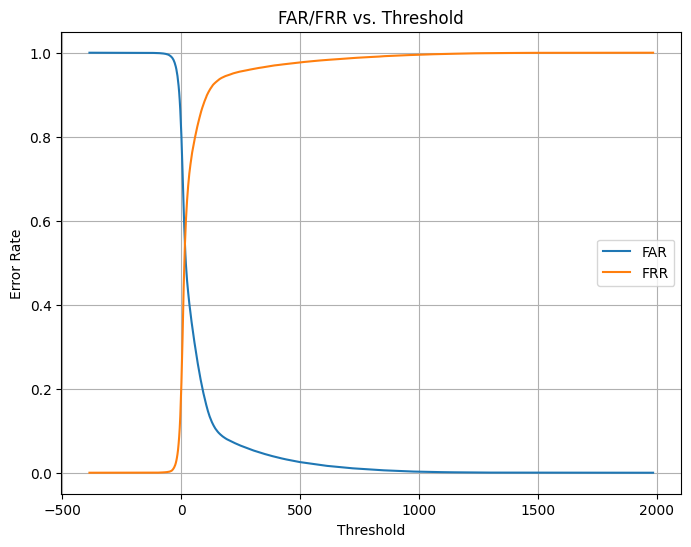

EER: 0.5434147185444518, Threshold: 14.81909634357936
Recall: 0.46353595072043047, Precision: 0.0899010254491275, F1: 0.15059477084717104, Accuracy: 0.4510938841341276, IoU: 0.08142875799921641


In [95]:
train_eer, train_eer_threshold = eval_plda_datasets(plda, train_dataset)

### Eval val datasets

  0%|          | 0/237 [00:00<?, ?it/s]<ipython-input-14-dd59bd130758>:45: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  X_centered = X - self.mean_vec
<ipython-input-14-dd59bd130758>:46: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.dot(X_centered, self.V)
100%|██████████| 1000/1000 [00:00<00:00, 1011.62it/s]


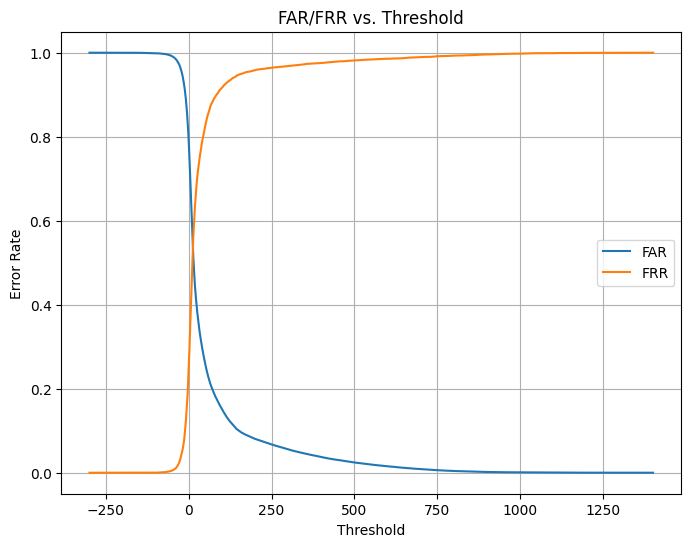

EER: 0.5370179446705869, Threshold: 12.002424034087767
Recall: 0.4727367403109425, Precision: 0.09528736149221058, F1: 0.1586053708695218, Accuracy: 0.45534589162816247, IoU: 0.08613328634743363


In [96]:
val_eer, val_eer_threshold = eval_plda_datasets(plda, val_dataset)

### Eval test datasets

  0%|          | 0/244 [00:00<?, ?it/s]<ipython-input-14-dd59bd130758>:45: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  X_centered = X - self.mean_vec
<ipython-input-14-dd59bd130758>:46: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.dot(X_centered, self.V)
100%|██████████| 1000/1000 [00:00<00:00, 1034.80it/s]


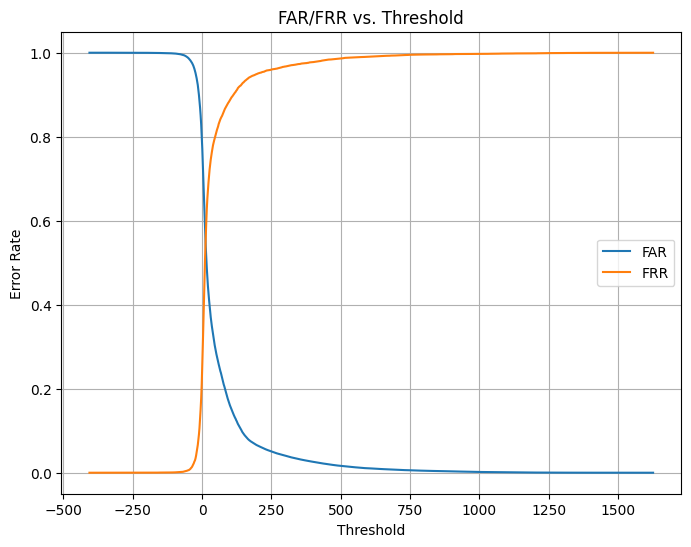

EER: 0.5499533050509698, Threshold: 12.995774738715909
Recall: 0.44099984987239155, Precision: 0.0835027076197109, F1: 0.14041754801085096, Accuracy: 0.45727479193861154, IoU: 0.0755102565420801


In [97]:
test_eer, test_eer_threshold = eval_plda_datasets(plda, test_dataset)

### Eval test from val threshold

In [98]:
def eval_plda(plda_model):
  all_labels_val, all_similarities_val = cal_similarities(plda_model, val_dataset)
  all_labels_test, all_similarities_test = cal_similarities(plda_model, test_dataset)
  eer_val, eer_threshold_val = plot_far_frr(all_labels_val, all_similarities_val)

  print_eval_metrics(all_labels_test, all_similarities_test, eer_threshold_val)

  return eer_val, eer_threshold_val

  0%|          | 0/237 [00:00<?, ?it/s]<ipython-input-14-dd59bd130758>:45: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  X_centered = X - self.mean_vec
<ipython-input-14-dd59bd130758>:46: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.dot(X_centered, self.V)
100%|██████████| 1000/1000 [00:00<00:00, 1118.19it/s]


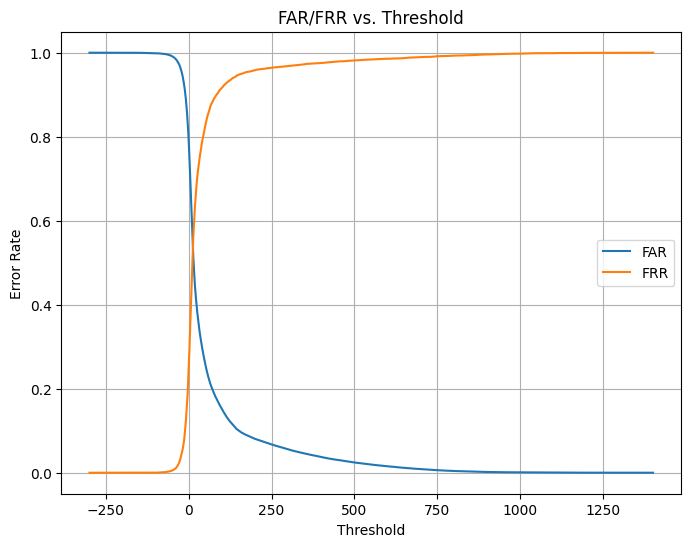

EER: 0.5370179446705869, Threshold: 12.002424034087767
Recall: 0.4620927788620327, Precision: 0.08489512225394068, F1: 0.14343799149531078, Accuracy: 0.44524759871126435, IoU: 0.07726000577316483


(np.float64(0.5370179446705869), np.float64(12.002424034087767))

In [99]:
eval_plda(plda)